In [1]:
library(tidyverse)
library(ncdf4)
library(viridis)
library(fields)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘purrr’ was built under R version 3.6.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: viridisLite

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: maps


A

In [2]:
nc <- nc_open("data/Zinser_SizeDist_calibrated-26-6.nc")
PAR   <- ncvar_get(nc,'PAR')
w_obs <- ncvar_get(nc,'w_obs')
m     <- ncvar_get(nc,'m')
delta_v_inv <- ncvar_get(nc,'delta_v_inv')
v_min       <- ncvar_get(nc,'v_min')
time  <- ncvar_get(nc,'time')
time <- as.POSIXct(time*60, origin="2009-05-01")
delta_v <- 1/delta_v_inv
v       <- v_min*2^(0:25*delta_v) 

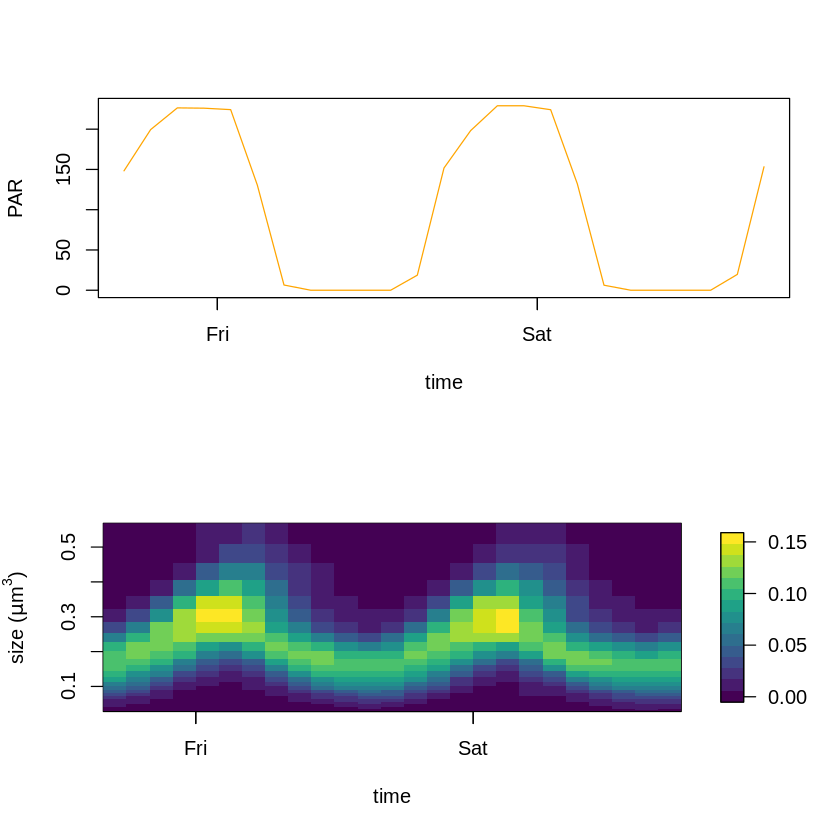

In [3]:
par(mfrow=c(2,1))
plot(time,PAR,type='l',col='orange')
image.plot(x=time,y=v,w_obs,col=viridis(15),xlab='time',ylab=expression('size ('*mu*'m'^3*')'))

In [112]:
df <- read.csv("data/Zinser_Figure2A.csv")
abundance <- rowMeans(df[,c(3,2)]) # mean of culture A and B

clean <- smooth.spline(time, abundance, df=10) # smooth abundance data using spline


df2 <- read.csv("data/Zinser_Figure3.csv")

- ### Equation division rate (assuming exponential growth)
$$
DR = ln(\frac{N_1/N_0}t)

In [5]:
dr <- diff(log(clean$y))/diff(clean$x/3600) # calculate hourly division rate

[1] "Division rate =  0.63 / day"


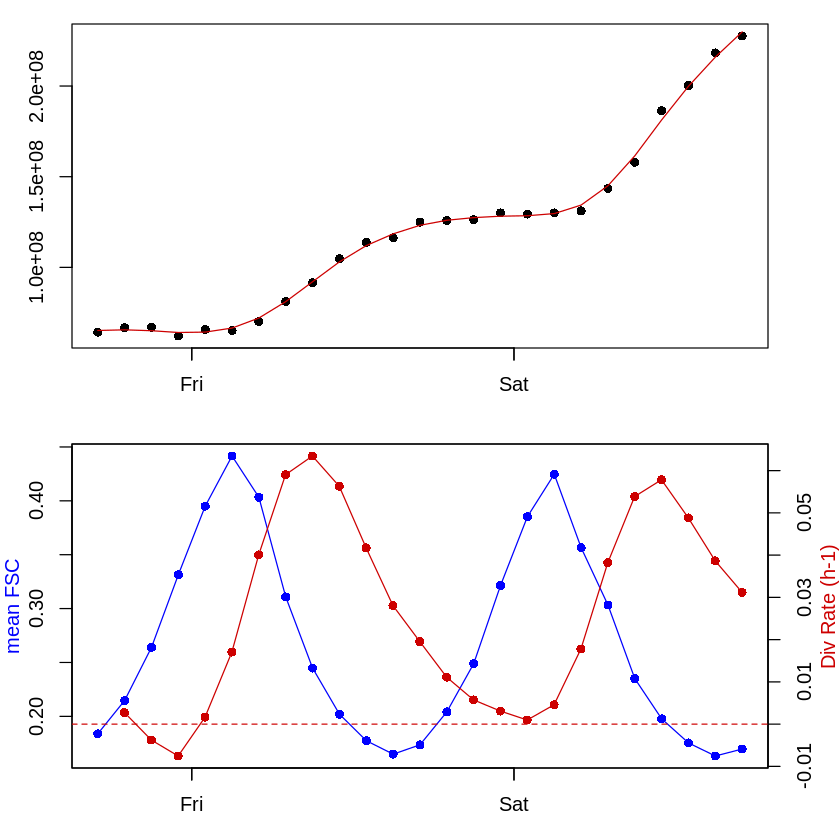

In [6]:
par(mfrow=c(2,1), mar=c(3,3,1,3))
plot(time, abundance, pch=NA)
#polygon(x=rep(c(1200,1800,2640,3240),each=2), y=rep(c(1,10^9,10^9,1),2), border=NA, col='lightgrey')
points(time, abundance, pch=16)
lines(clean,col="red3" )
plot(time, df[,c(4)], pch=NA, xlab=NA, ylab=NA)
#polygon(x=rep(c(1200,1800,2640,3240),each=2), y=rep(c(-1,1,1,-1),2), border=NA, col='lightgrey')
lines(time, df[,c(4)], col='blue1', type="o", pch=16)
par(new=T)
plot(x=time[-1]-50,y=dr, type='o', pch=16, xaxt='n', yaxt='n', col="red3", xlab=NA, ylab=NA, xlim=range(time))
axis(4) 
mtext("Div Rate (h-1)", 4,2, col="red3")
mtext("mean FSC", 2,2, col="blue1")
abline(h=0, lty=2,col="red3")
print(paste("Division rate = ",round(24*mean(dr),3), "/ day"))


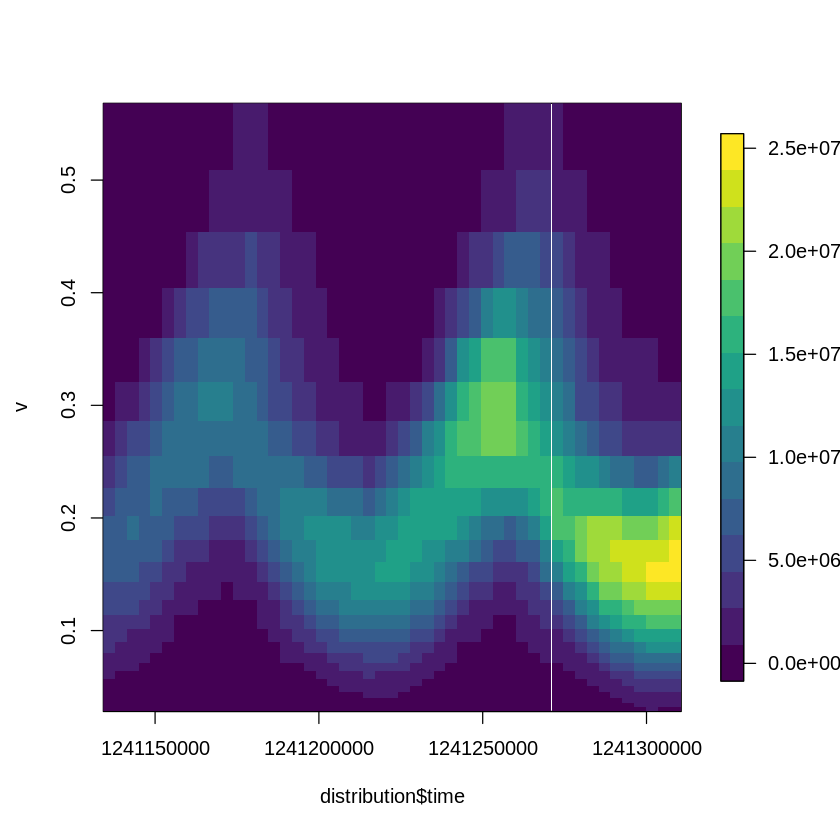

In [36]:
w_obs2 <- round(w_obs * abundance)
dist <- as.data.frame(w_obs2)
dist$time <- time

dist <- dist[,c(27,1:26)] # reorganize dataframe to be compatible with ssPopModel


# Extrapoltae dat to 1 hour interval
DF <- NULL
for(i in 1:dim(dist)[2]){
     df <- approx(dist$time, dist[,i], xout=seq(min(time), max(time), by=3600))
     DF <- cbind(DF, df$y)
    }
colnames(DF) <- c("time", v)

### select 1 day Size distribution
id <- c(1:25)   
distribution <- as.data.frame(DF[,])

image.plot(x=distribution$time,y=v,z=as.matrix(distribution[,-c(1)]), col=viridis(15))

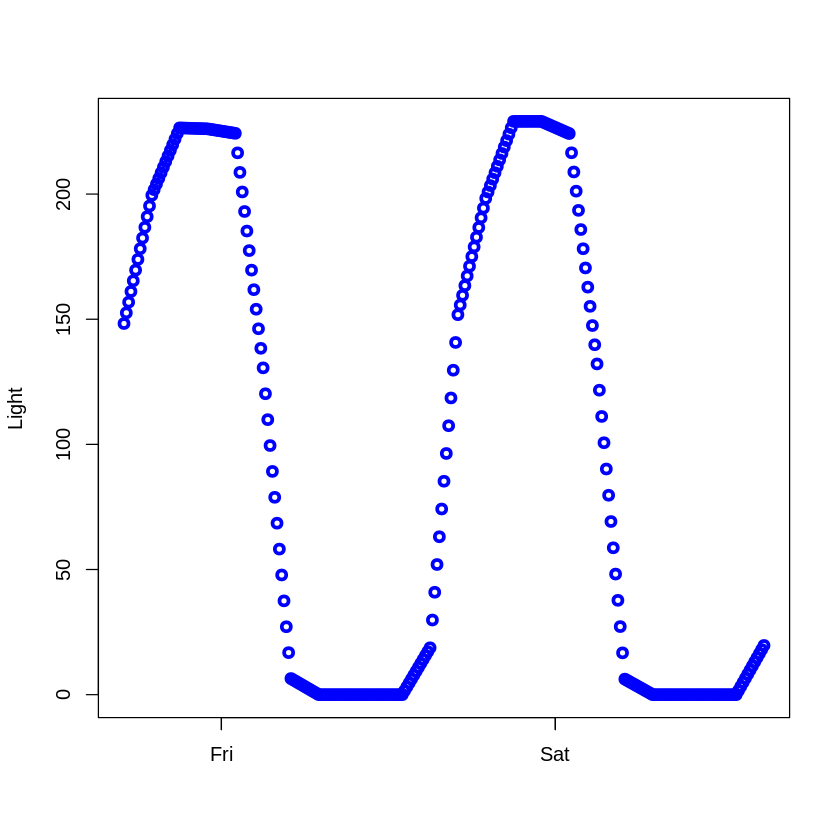

In [37]:
## PAR data
# resolution
resol <- 10

# select PAR data covering the range of the size distribution
par <- data.frame(time=time, par=PAR)
par <- subset(par, time  >= min(distribution$time) & time  < max(distribution$time))

# Change temporal resolution from  2 hours to 10 minutes
E <- approx(par$time, par$par, xout=seq(min(par$time), max(par$time), by=60*resol))

# smooth spline
ep <- smooth.spline(E, all.knots=TRUE)
Edata <- ep$y
Edata[Edata < 0] <- 0

#plot
plot(par$time,par$par, type='p', xlab=NA, ylab="Light")
points(ep$x,Edata, col=4, lwd=3)

In [38]:
source("scripts/functions_model.R")

output <- determine_opt_para(distribution,Edata,resol)

[1] "Optimizing gmax, dmax, b and E_star"
Iteration: 10 bestvalit: 90291.238234 bestmemit:    0.367207    0.075840    0.343795    0.751067
Iteration: 20 bestvalit: 90048.604167 bestmemit:    0.370135    0.075347    0.353195    0.706430
Iteration: 30 bestvalit: 89967.001309 bestmemit:    0.343099    0.073069    0.343795    0.668866
Iteration: 40 bestvalit: 89967.001309 bestmemit:    0.343099    0.073069    0.343795    0.668866
Iteration: 50 bestvalit: 89962.191731 bestmemit:    0.318904    0.072985    0.339934    0.614758
Iteration: 60 bestvalit: 89960.116940 bestmemit:    0.361611    0.071827    0.337369    0.703485
Iteration: 70 bestvalit: 89959.839557 bestmemit:    0.361611    0.071827    0.337369    0.702250
Iteration: 80 bestvalit: 89959.309726 bestmemit:    0.428321    0.072348    0.339197    0.831245
Iteration: 90 bestvalit: 89959.274794 bestmemit:    0.428321    0.072348    0.339037    0.831245
Iteration: 100 bestvalit: 89959.274794 bestmemit:    0.428321    0.072348    0.339037

In [39]:
params <- output$parameters
        gmax <- as.numeric(params[1]) 
        dmax <- as.numeric(params[2]) 
        b <- as.numeric(params[3]) 
        E_star <- as.numeric(params[4])

resnorm <- as.numeric(params[5])

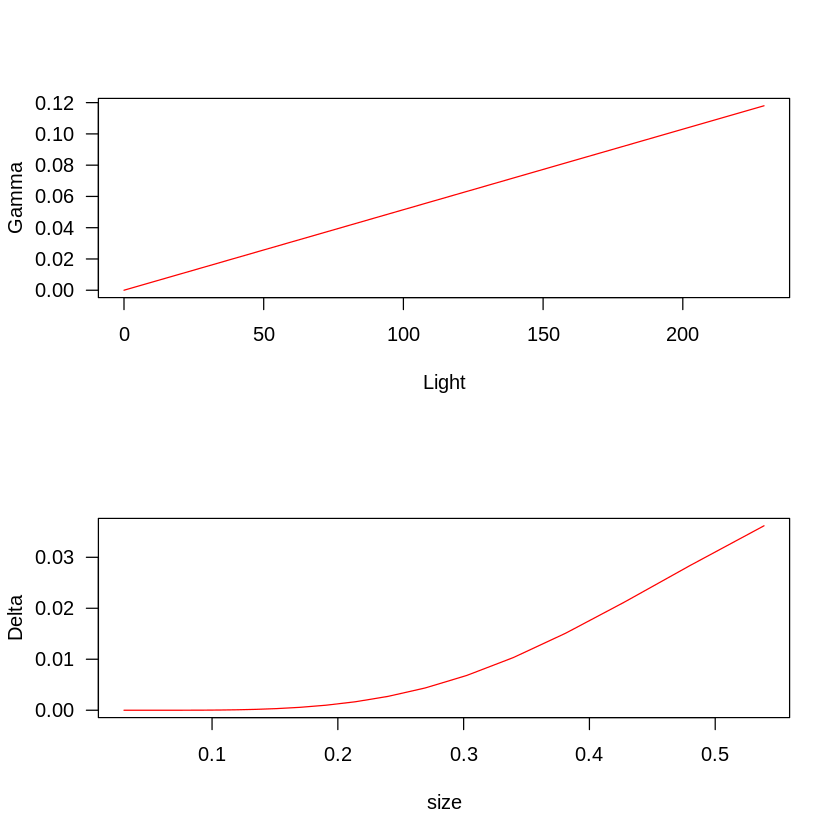

In [40]:
par(mfrow=c(2,1))
plot(Edata, gamma_t(Edata, gmax, E_star), type='l', col='red', xlab="Light", ylab=paste("Gamma"), las=1)
plot(v, delta(v, dmax, b), type='l', col='red', xlab="size", ylab=paste("Delta"), las=1)    

[1] "daily growth rate= 0.69"


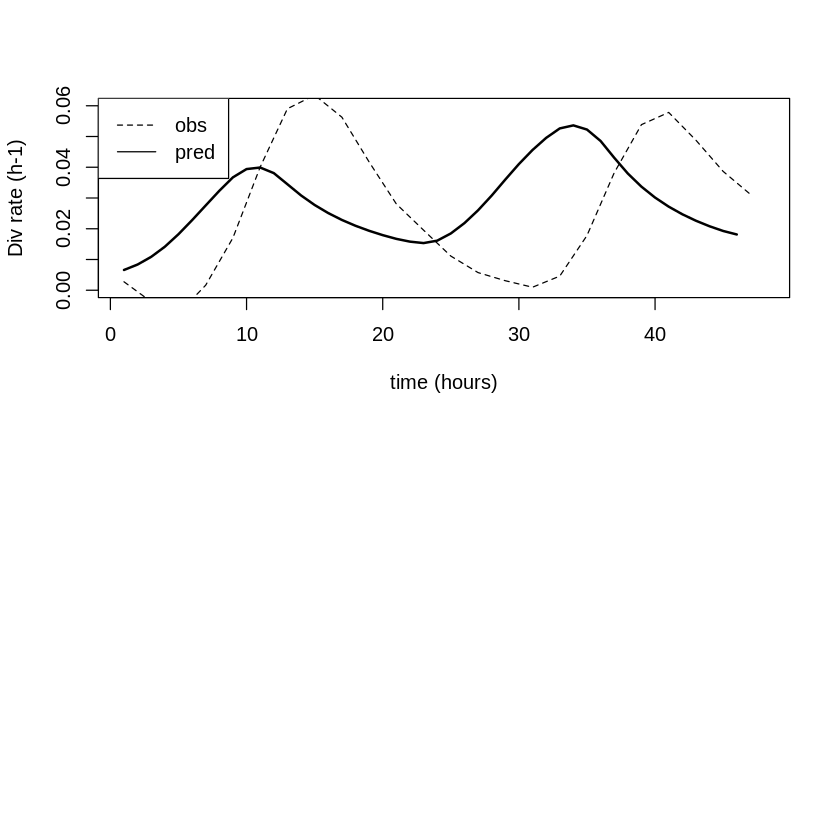

In [57]:
###############################
## Division rate calculation ##
###############################
PSD <- output$PSD
mu_N <- diff(log(rowSums(PSD[,-c(1)], na.rm=T))) / as.numeric(diff(PSD$time)/3600)
d.mu_N <- 24*mean(mu_N[1:45], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N,2)))

#plot
par(mfrow=c(2,1))
plot(mu_N,type='l', ylim=c(0,0.06), xlab='time (hours)', ylab="Div rate (h-1)", lwd=2)
lines(seq(1,48,2), y=dr, lty=2)
legend("topleft",c("obs","pred"), lty=c(2,1))

Warning message in diff(colSums(biom))/rowSums(Nproj):
“longer object length is not a multiple of shorter object length”


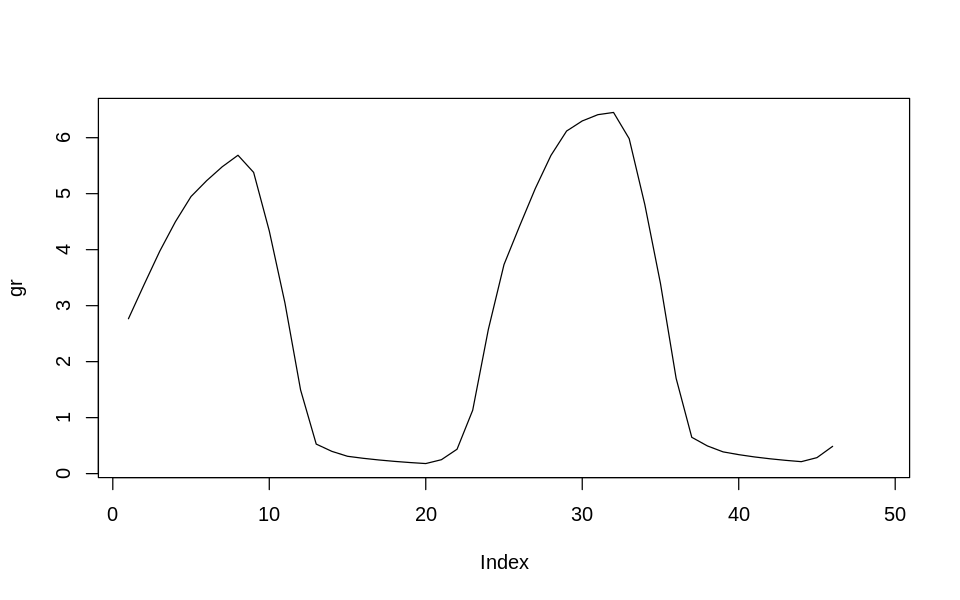

In [294]:
#############################
## Growth rate calculation ##
#############################
#c <- v  * 256 # based on Binder 
c <- 261 * v^0.861 # Menden-Deuer
light <- approx(par$time, par$par, xout=seq(min(par$time), max(par$time), by=60 * 60))$y
biom <-  diag(c) %*%  t(Nproj) 
gr <- diff(colSums(biom)) / rowSums(Nproj)

options(repr.plot.width = 8, repr.plot.height = 5)

plot(gr, type="l")

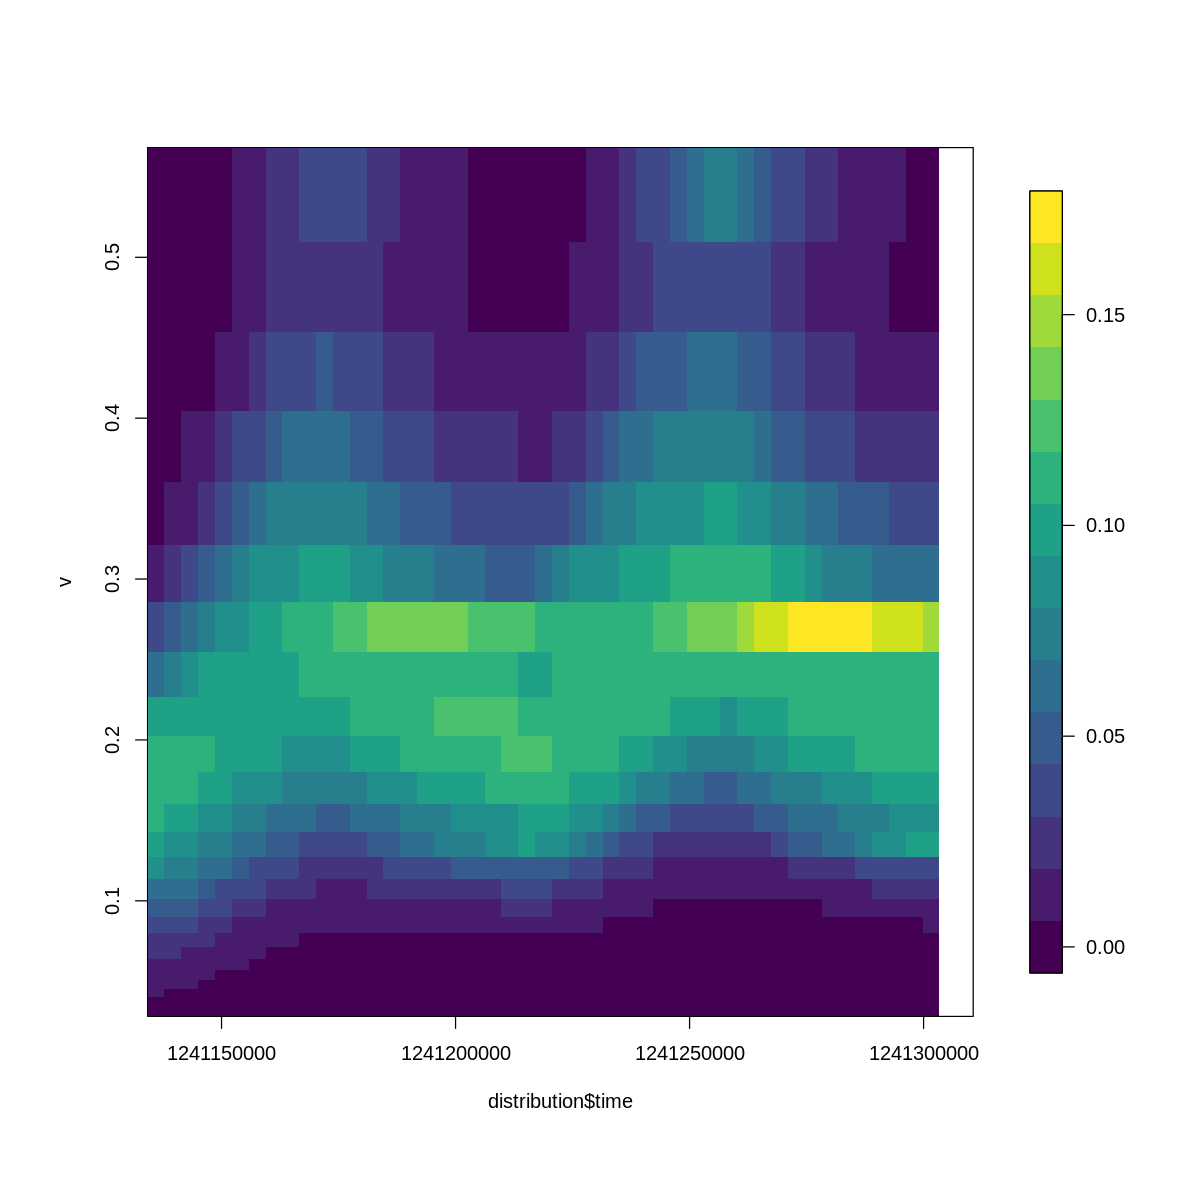

In [89]:
### plot size distribution
Nproj <- as.matrix(PSD[,-c(1)])

### plot frequency distribution
s2 <- round(apply(Nproj, 1, function(x) sum(x,na.rm=T)))
Vproj <- as.matrix(Nproj/s2)

image.plot(x=distribution$time,y=v,z=as.matrix(Vproj), col=viridis(15))

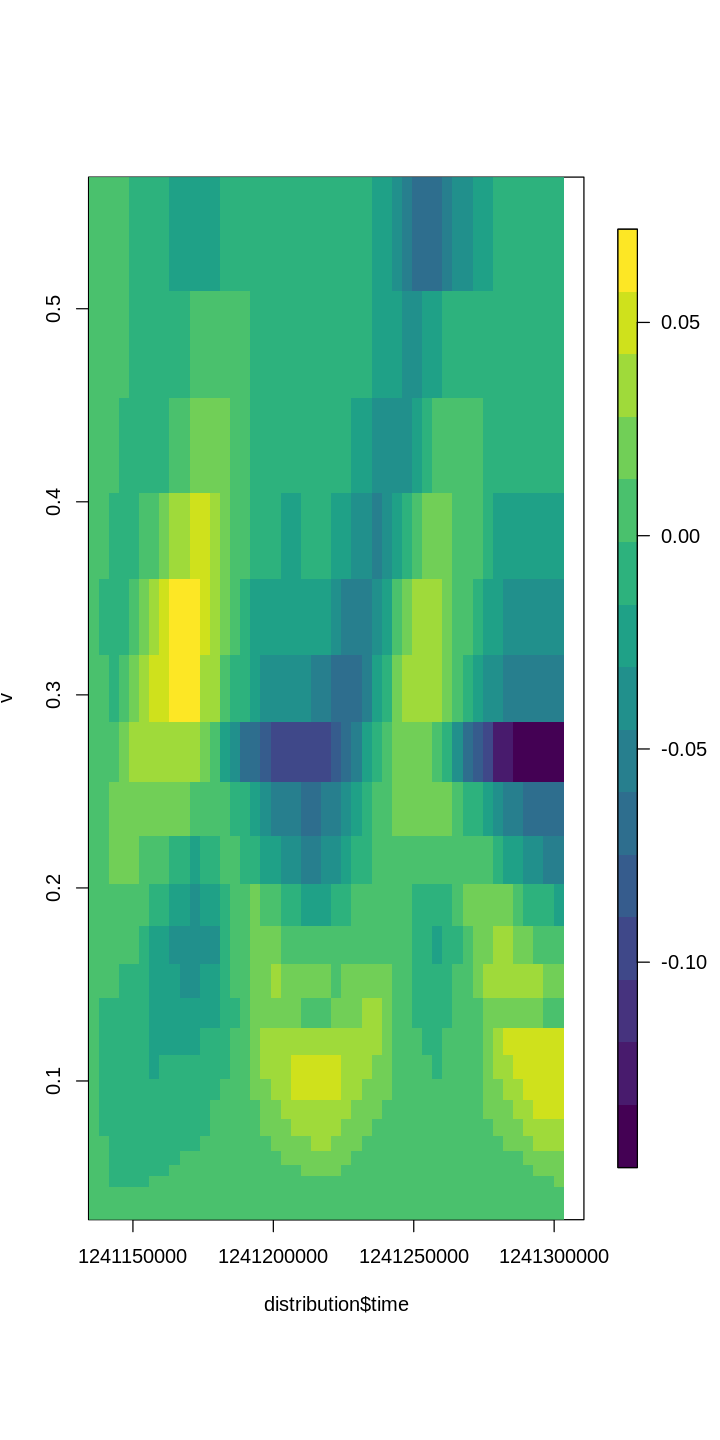

In [364]:
### plot difference Observed - Projected
s <- round(apply(distribution[,-c(1)], 1, function(x) sum(x,na.rm=T)))                   
z <- as.matrix(distribution[,-c(1)]/s) - Vproj

image.plot(x=distribution$time,y=v,z=z, col=viridis(15))

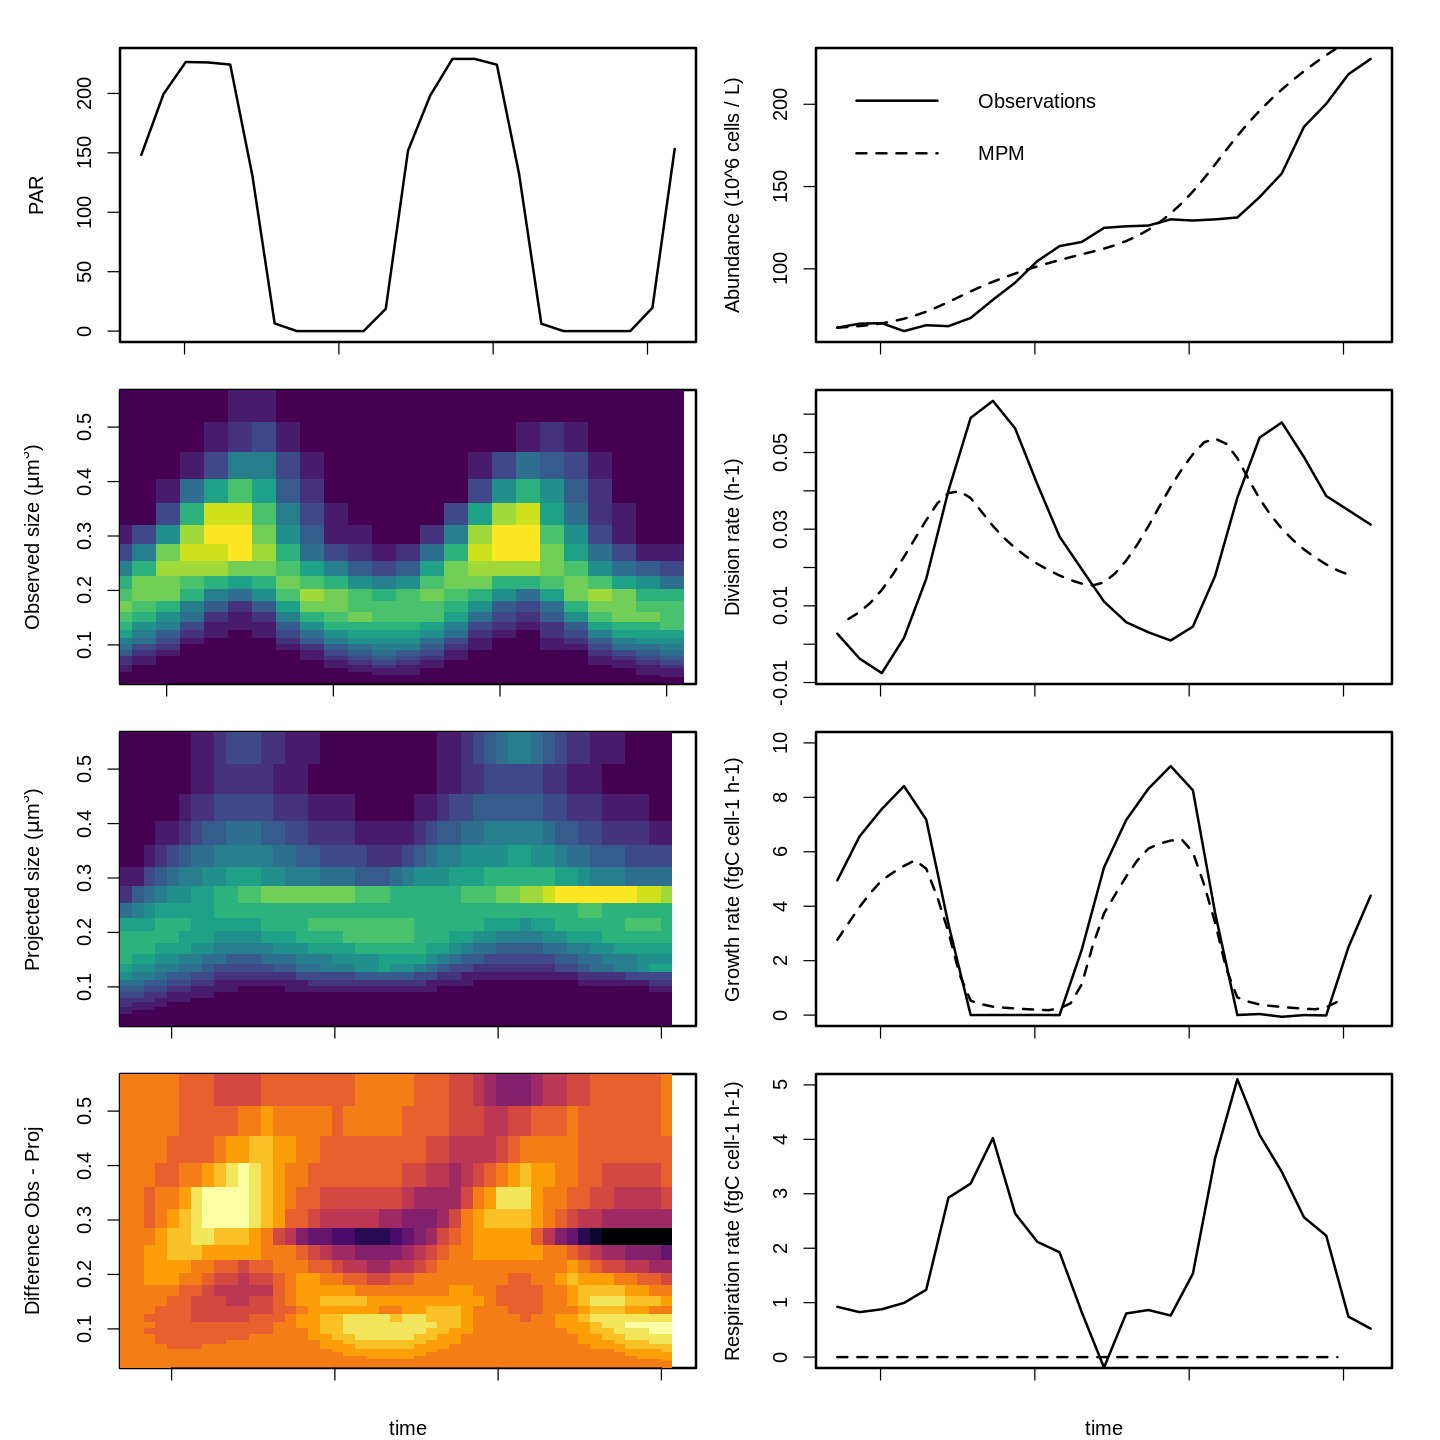

In [377]:
## Comparison Obs vs Model
options(repr.plot.width = 12, repr.plot.height = 12)
layout(matrix(c(1:8), 4, 2, byrow = FALSE))

par(mar=c(1,4,1,1), oma=c(2,1,1,1), lwd=2, cex=1)

plot(time,PAR,type='l',xaxt='n')
axis(1,labels=NA)
image(x=time[-25],y=v,w_obs[-25,],col=viridis(15), ylab=expression('Observed size ('*mu*'m'^3*')'), xaxt="n", xlim=range(time))
axis(1,labels=NA)
image(x=distribution$time,y=v,Vproj,col=viridis(15),ylab=expression('Projected size ('*mu*'m'^3*')'), xaxt="n")
axis(1,labels=NA)
image(x=distribution$time,y=v,z,col=viridis(15, option="B"),ylab=expression('Difference Obs - Proj'), xaxt="n")
axis(1, labels=NA)
mtext("time", 1, 2)

plot(time, abundance/10^6, type='l', xaxt="n", ylab="Abundance (10^6 cells / L)", xlim=range(time))
lines(distribution$time, rowSums(Nproj)/10^6, lty=2)
legend("topleft", c("Observations","MPM"), lty=c(1,2), bty="n")
axis(1,labels=NA)

plot(x=time[-24],y=dr, type='l', xaxt='n',xlim=range(time), ylab="Division rate (h-1)")
lines(x=distribution$time[-c(1)],y=mu_N, lty=2)
axis(1,labels=NA)
plot(time, df2[,3], type='l', xaxt="n", ylim=c(0,10), xlim=range(time),ylab="Growth rate (fgC cell-1 h-1)")
lines(x=distribution$time,y=gr, lty=2)
axis(1,labels=NA)
plot(time, 0.5 * ( - df2[,3] + df2[,7]), xaxt="n", type='l', ylim=c(0,5), xlim=range(time), ylab="Respiration rate (fgC cell-1 h-1)")
lines(x=distribution$time, y = gr *0, lty=2)
axis(1, labels=NA)
mtext("time", 1, 2)

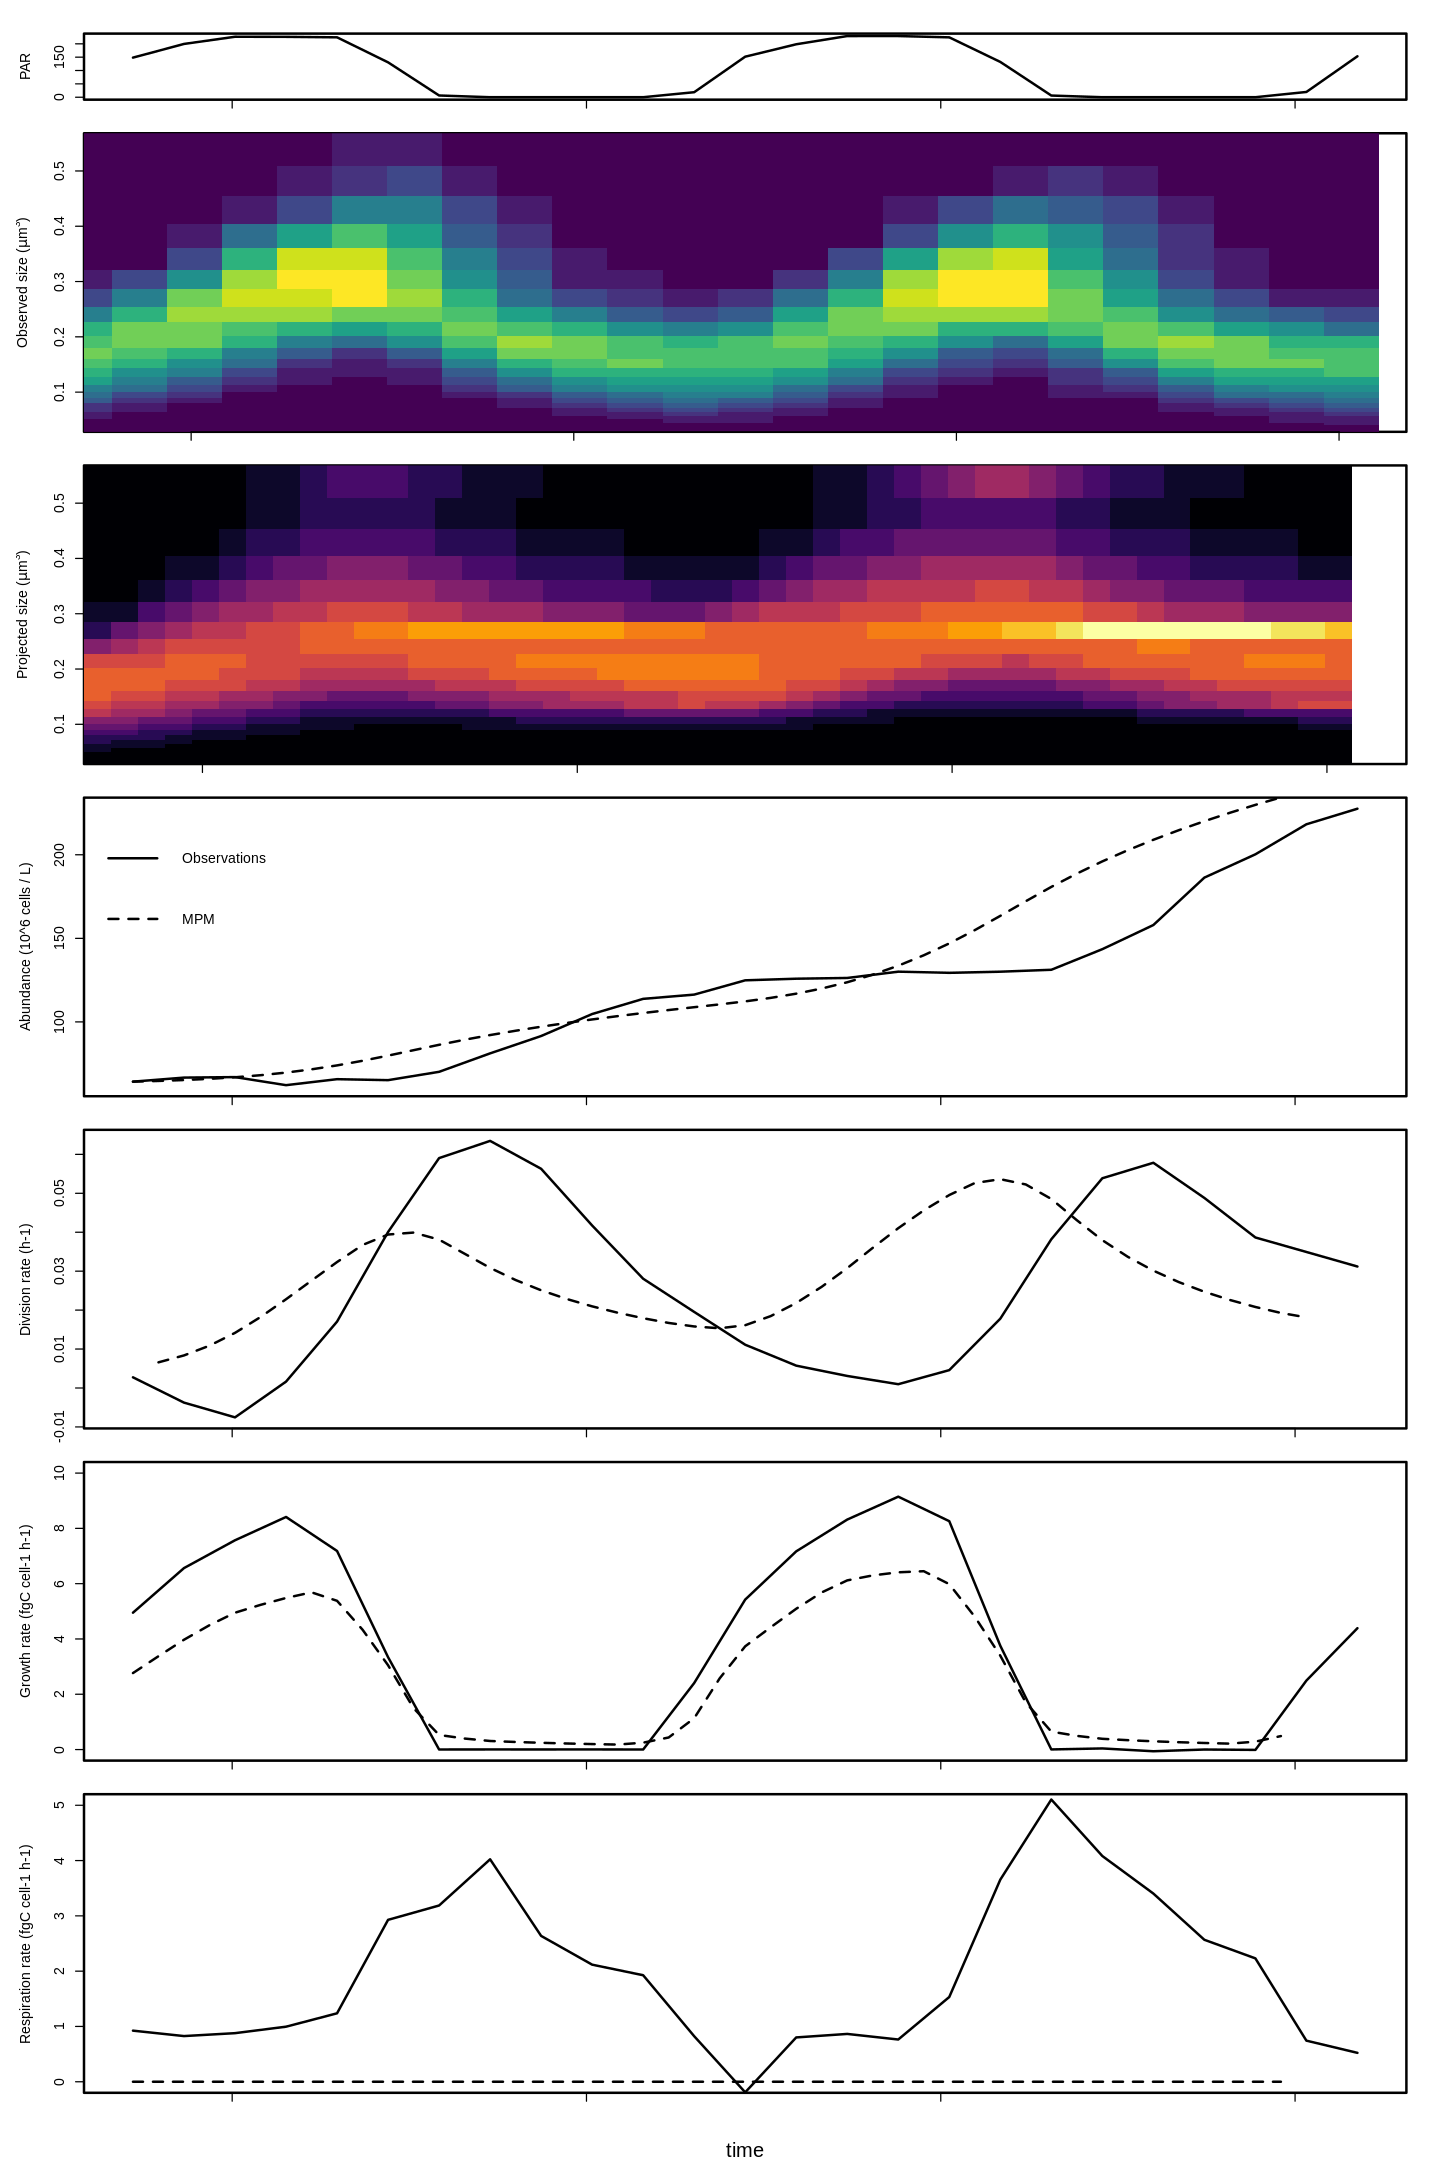

In [380]:
## Comparison Obs vs Model
options(repr.plot.width = 12, repr.plot.height = 18)
layout(matrix(c(1:7), 7, 1, byrow = FALSE),
       heights=c(0.3,1,1,1,1,1,1))

par(mar=c(1,4,1,1), oma=c(3,1,1,1), lwd=2, cex=0.7)

plot(time,PAR,type='l',xaxt='n')
axis(1,labels=NA)
image(x=time[-25],y=v,w_obs[-25,],col=viridis(15), ylab=expression('Observed size ('*mu*'m'^3*')'), xaxt="n", xlim=range(time))
axis(1,labels=NA)
image(x=distribution$time,y=v,Vproj,col=viridis(15, option="B"),ylab=expression('Projected size ('*mu*'m'^3*')'), xaxt="n")
axis(1,labels=NA)
plot(time, abundance/10^6, type='l', xaxt="n", ylab="Abundance (10^6 cells / L)", xlim=range(time))
lines(distribution$time, rowSums(Nproj)/10^6, lty=2)
legend("topleft", c("Observations","MPM"), lty=c(1,2), bty="n")
axis(1,labels=NA)
plot(x=time[-24],y=dr, type='l', xaxt='n',xlim=range(time), ylab="Division rate (h-1)")
lines(x=distribution$time[-c(1)],y=mu_N, lty=2)
axis(1,labels=NA)
plot(time, df2[,3], type='l', xaxt="n", ylim=c(0,10), xlim=range(time),ylab="Growth rate (fgC cell-1 h-1)")
lines(x=distribution$time,y=gr, lty=2)
axis(1,labels=NA)
plot(time, 0.5 * ( - df2[,3] + df2[,7]), xaxt="n", type='l', ylim=c(0,5), xlim=range(time), ylab="Respiration rate (fgC cell-1 h-1)")
lines(x=distribution$time, y = gr *0, lty=2)
axis(1, labels=NA)
mtext("time", 1, 3)